# Mental Health Analysis Project

This project aims to analyse the mental_health database which stores answers of mental health surveys of various people between year 2014 and 2019.

## Project goals
* Analyse race distribution in the dataset
* Analyse the gender distribution and its relation to mental health issues
* Understand the correlation between self employed people and their likeliness to seek for mental health help
* Understand how remote work impacts people tendency to seek for mental health help
* See what percentage of all people seek for mental health help yearly
* See what percent of people who sought for mental health help actually were diagnosed with mental health disorder
* Understand what mental health disorders and the most frequent
* See what percent of people have ever discussed mental health issues with their employers


In [898]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import norm
import numpy as np
import statistics
from wordcloud import WordCloud, STOPWORDS
from nltk import ngrams

 # Data Cleaning

Checking what kind of tables there is in the database

In [899]:
db = sqlite3.connect("mental_health.sqlite")

In [900]:
'''List of Tables'''
query = "SELECT name FROM  sqlite_master WHERE type ='table';"
df = pd.read_sql(sql=query, con=db)
df.head()

,name
0,Answer
1,Question
2,Survey


Viewing different types of tables from the database

In [901]:
'''Answer Table'''
answer = pd.read_sql(sql='SELECT * FROM  Answer;', con=db)
answer.head()

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


In [902]:
answer.isnull().sum()

AnswerText    0
SurveyID      0
UserID        0
QuestionID    0
dtype: int64

In [903]:
'''Question Table'''
question = pd.read_sql(sql='SELECT * FROM  Question;', con=db)
question.head()

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5


In [904]:
question.isnull().sum()

questiontext    0
questionid      0
dtype: int64

In [905]:
'''Survey Table'''
survey = pd.read_sql(sql='SELECT * FROM  Answer;', con=db)
survey.head()

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


In [906]:
survey.isnull().sum()

AnswerText    0
SurveyID      0
UserID        0
QuestionID    0
dtype: int64

We see that there is no null values so we can start the EDA!

# Exploratory Data Analysis

In [907]:
qr = """SELECT DISTINCT SurveyID, COUNT(DISTINCT UserID) AS users, count(UserID) AS total_answers
        FROM Answer GROUP BY SurveyID"""
df_answers_num_by_year = pd.read_sql(sql=qr, con=db) 
df_answers_num_by_year

,SurveyID,users,total_answers
0,2014,1260,32760
1,2016,1433,88238
2,2017,756,57456
3,2018,417,31692
4,2019,352,26752


### Observations
* Maximum number of users participated in the survey was in year 2016 with 1433 unique users
* Minimum number of users participated in the survey was in year 2018 with 417 unique users

In [908]:
plt.rcParams["figure.figsize"] = (15,7)

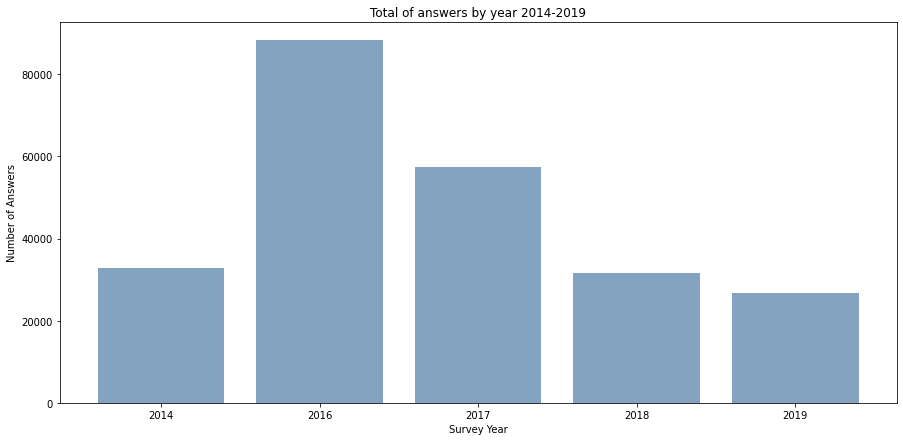

In [909]:
years = list(df_answers_num_by_year['SurveyID'])
total_answers = list(df_answers_num_by_year['total_answers']) 

plt.bar(range(len(years)), total_answers, tick_label=years, color=(0.2, 0.4, 0.6, 0.6))
plt.title('Total of answers by year 2014-2019')   
plt.xlabel('Survey Year')   
plt.ylabel('Number of Answers')    
plt.show() 

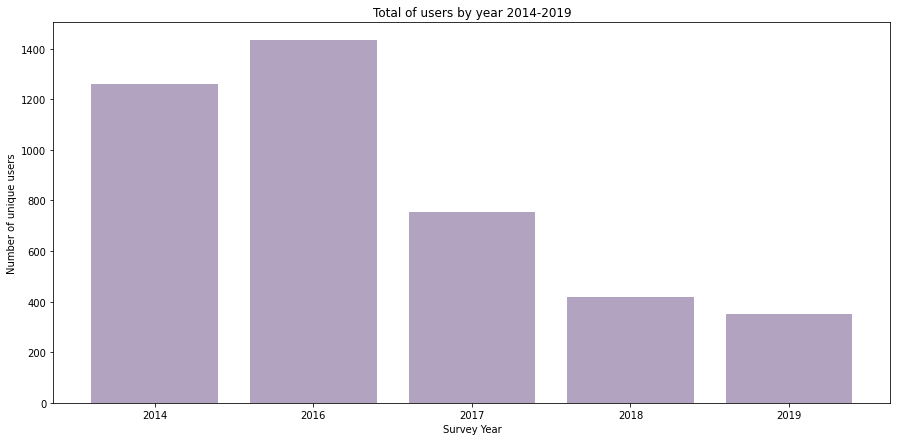

In [910]:
total_answers = list(df_answers_num_by_year['users']) 
plt.bar(range(len(years)), total_answers, tick_label=years, color=(0.5, 0.4, 0.6, 0.6))
plt.title('Total of users by year 2014-2019')   
plt.xlabel('Survey Year')   
plt.ylabel('Number of unique users')    
plt.show() 

I also check how many questions there was in the survey. We can see that in 2014 there was only 26 questions. In the following years 34 new questions were added. And in the year 2017, 2018 and 2019 the seame amount of questions were used.

In [911]:
qr = """SELECT DISTINCT SurveyID, COUNT(DISTINCT QuestionID) AS questions
        FROM Answer GROUP BY SurveyID"""
df_question_num_by_year = pd.read_sql(sql=qr, con=db) 
df_question_num_by_year

,SurveyID,questions
0,2014,26
1,2016,60
2,2017,76
3,2018,76
4,2019,76


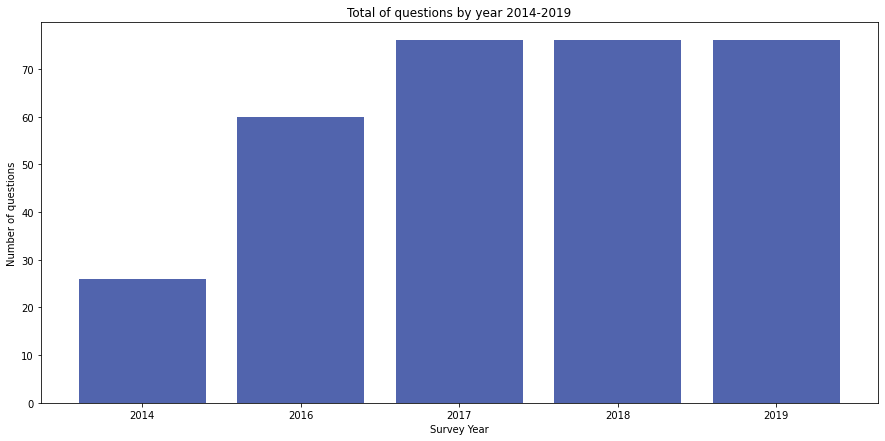

In [912]:
total_questions = list(df_question_num_by_year['questions']) 

plt.bar(range(len(years)), total_questions, tick_label=years, color=(0.15, 0.24, 0.6, 0.8))
plt.title('Total of questions by year 2014-2019')   
plt.xlabel('Survey Year')   
plt.ylabel('Number of questions')    
plt.show() 

### Examination of question types

As discussed before, the dataset has a large number of questions. Therefore, I will conduct an analysis of types of questions to see which ones I will be using for further analysis.

In [913]:
all_questions = pd.read_sql_query("SELECT DISTINCT(question.questiontext) FROM question", con=db)
all_questions = list(all_questions['questiontext'])
all_questions = " ".join(all_questions)

I plotted a wordcloud to see the topics of the questions.

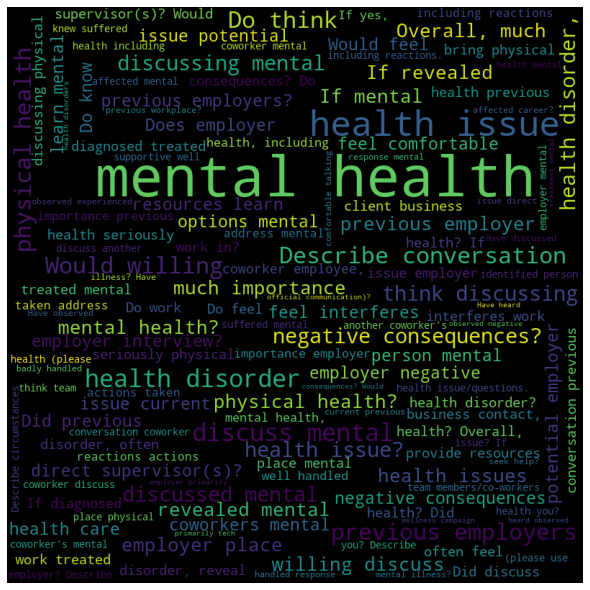

In [914]:
ngram = []

all_questions = all_questions.split(" ")
all_questions = [q for q in all_questions if q not in set(STOPWORDS)]
all_questions = " ".join(all_questions)

for grams in ngrams(all_questions.split(), 2):
  grams = " ".join(grams)
  ngram.append(grams)

count = pd.Series(ngram).value_counts() 

wordcloud = WordCloud(collocations=False,
                      width = 800, height = 800,
                      background_color ='black', 
                      min_font_size = 10).generate_from_frequencies(count)
                    
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

We see that the most popular pair of words is "mental health"

In [915]:
count

mental health         72
health issue          19
health disorder        7
discuss mental         7
Do think               6
                      ..
current workplace?     1
reveal mental          1
likely reveal          1
less likely            1
work remotely?         1
Length: 543, dtype: int64

First, I choose questions that start with words "What is your", this will help me to understand the types of users.

In [916]:
q1 = pd.read_sql_query("SELECT DISTINCT(question.questiontext), question.QuestionID FROM question WHERE question.questiontext LIKE '%what is your%'", con=db)
q1

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What is your race?,89


Second type of questions will be used to determine the type of workplace people work in. Therefore, I filtered questions that have substring "do you work" inside.

In [917]:
q2 = pd.read_sql_query("SELECT DISTINCT(question.questiontext), question.QuestionID FROM question WHERE question.questiontext LIKE '%Do you work%'", con=db)
q2

,questiontext,questionid
0,What country do you work in?,50
1,What US state or territory do you work in?,51
2,Do you work remotely (outside of an office) at...,93
3,Do you work remotely?,118


Also, I chose to use substring "are you" inside the question to further gather information about employment type and information about the user.

In [918]:
q3 = pd.read_sql_query("SELECT DISTINCT(question.questiontext), question.QuestionID FROM question WHERE question.questiontext LIKE 'Are you%'", con=db)
q3 

,questiontext,questionid
0,Are you self-employed?,5
1,Are you openly identified at work as a person ...,78


Furthermore, as this is a mental health dataset I used a word "diagnosed" to find questions related to diagnosis of the conditions.

In [919]:
q4 = pd.read_sql_query("SELECT DISTINCT(question.questiontext), question.QuestionID FROM question WHERE question.questiontext LIKE '%diagnosed%'", con=db)
q4  

,questiontext,questionid
0,Have you ever been diagnosed with a mental hea...,34
1,If you have been diagnosed or treated for a me...,52
2,If you have been diagnosed or treated for a me...,53
3,"If yes, what condition(s) have you been diagno...",115


Also, a word "discussed" will be useful to understand whether it is popular to discuss mental health in the workplace.

In [920]:
q5 = pd.read_sql_query("SELECT DISTINCT(question.questiontext), question.QuestionID FROM question WHERE question.questiontext LIKE '%discussed%'", con=db)
q5 

,questiontext,questionid
0,Has your employer ever formally discussed ment...,15
1,Have your observations of how another individu...,31
2,Have you ever discussed your mental health wit...,58
3,Have you ever discussed your mental health wit...,60
4,Has your employer ever discussed mental health...,95


And finally, I chose word "treatment" to further categorize the questions

In [921]:
q6 = pd.read_sql_query("SELECT DISTINCT(question.questiontext), question.QuestionID FROM question WHERE question.questiontext LIKE '%treatment%'", con=db)
q6  

,questiontext,questionid
0,Have you ever sought treatment for a mental he...,7
1,Is your anonymity protected if you choose to t...,11
2,Do you have medical coverage (private insuranc...,20
3,Was your anonymity protected if you chose to t...,27


In [922]:
q7 = pd.read_sql_query("SELECT DISTINCT(question.questiontext), question.QuestionID FROM question WHERE question.questiontext LIKE '%company%'", con=db)
q7 

,questiontext,questionid
0,How many employees does your company or organi...,8
1,Is your employer primarily a tech company/orga...,9
2,Is your primary role within your company relat...,13
3,Was your employer primarily a tech company/org...,68


The question analysis helped me to gather questions that will be useful for my further analysis:

***User Demographics Analysis Questions***
* What is your age?
* What is your gender?
* What is your race?
* What country do you work in?

***Work Type Analysis Questions***
* Do you work remotely (outside of an office) at least 50% of the time?,
* Do you work remotely?
* Are you self-employed?
* How many employees does your company or organization have?

***Mental Health Related Questions***
* Are you openly identified at work as a person with a mental health issue?
* Have you ever been diagnosed with a mental health disorder?
* If yes, what condition(s) have you been diagnosed with?
* Have you ever sought treatment for a mental health disorder from a mental health professional?

***Work and mental health relationship questions***
* If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?
* Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?
* Have you ever discussed your mental health with your employer?
* Have you ever discussed your mental health with coworkers?

## Selected Questions Dataset Creation

First of all, I will create datasets for these selected questions for each year.

In [923]:
def create_user_df(df):
  x = pd.DataFrame()  
  questions = list(df['questiontext'].unique())
 
  for q in questions:  
    val = list(df[df['questiontext'] == q]['AnswerText']) 
    x['UserID'] = list(df[df['questiontext'] == q]['UserID'])  
    x[q] = val
  
  return x

In [924]:
def query_user(year):
  qr = '''SELECT DISTINCT(questiontext), AnswerText,
                  A.SurveyID, UserID, A.QuestionID, Description
            FROM Question Q
            JOIN Answer A ON A.QuestionID = Q.questionid 
            JOIN Survey S ON A.SurveyID == ''' + str(year) + '''
            WHERE A.QuestionID IN (1, 2, 8, 89, 50, 93, 118, 5, 78, 34, 7, 53, 15, 58, 60, 95) '''

  return pd.read_sql_query(qr, db)

In [925]:
df_2014 = create_user_df(query_user(2014))
df_2016 = create_user_df(query_user(2016))
df_2017 = create_user_df(query_user(2017))
df_2018 = create_user_df(query_user(2018))
df_2019 = create_user_df(query_user(2019))

## Analysis by selected questions

#### Age Distribution

We can see that ower the years median age was getting higher, but on average the median was around 30-35 years old.

In [926]:
def fix_age_dist_types(df):
  '''
  Function that extracts age distribution for later plotting
  '''
  df['What is your age?'] = pd.to_numeric(df['What is your age?']) 
  df['What is your age?'] = df[(df['What is your age?'] >= 15) & (df['What is your age?'] <= 118)]['What is your age?']
  df['What is your age?'] = df['What is your age?'].fillna(df['What is your age?'].mode()[0])

In [927]:
fix_age_dist_types(df_2014) 
fix_age_dist_types(df_2016)
fix_age_dist_types(df_2017)
fix_age_dist_types(df_2018)
fix_age_dist_types(df_2018)
fix_age_dist_types(df_2019)

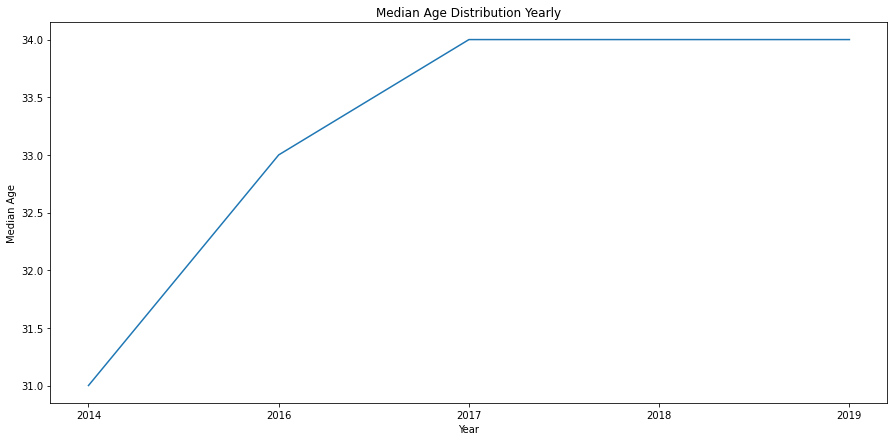

In [928]:
age_median_2014 = np.median(df_2014['What is your age?'])
age_median_2016 = np.median(df_2016['What is your age?'])
age_median_2017 = np.median(df_2017['What is your age?'])
age_median_2018 = np.median(df_2018['What is your age?'])
age_median_2019 = np.median(df_2019['What is your age?'])
 
plt.plot(['2014', '2016', '2017', '2018', '2019'],
         [age_median_2014, age_median_2016, age_median_2017, age_median_2018, age_median_2019]) 
plt.title('Median Age Distribution Yearly')
plt.xlabel('Year')
plt.ylabel('Median Age')
plt.show()

#### Gender Distribution

From the line graph below we can see that largest percentage of the users were men, then female and the smallest percentage was transexual people.

In [929]:
i = 0
years = [2014, 2016, 2017, 2018, 2019]
male_list = []
female_list  = []
trans_list = []

for year in years: 
  df_gender = pd.read_sql_query("SELECT AnswerText FROM Answer WHERE SurveyID==" + str(year) + " AND QuestionID==2",
                                con=db)
  
  female = len(df_gender[(df_gender['AnswerText'] == 'Female') | (df_gender['AnswerText'] == 'female')]) / len(df_gender) * 100
  male = len(df_gender[(df_gender['AnswerText'] == 'Male') | (df_gender['AnswerText'] == 'male')]) / len(df_gender) * 100
  trans = len(df_gender[(df_gender['AnswerText'].str.contains('Trans') == True) | 
                        (df_gender['AnswerText'].str.contains('trans') == True)]) / len(df_gender) * 100
  
  male_list.append(male)
  female_list.append(female)

  trans_list.append(trans)

Text(0, 0.5, '% of all people')

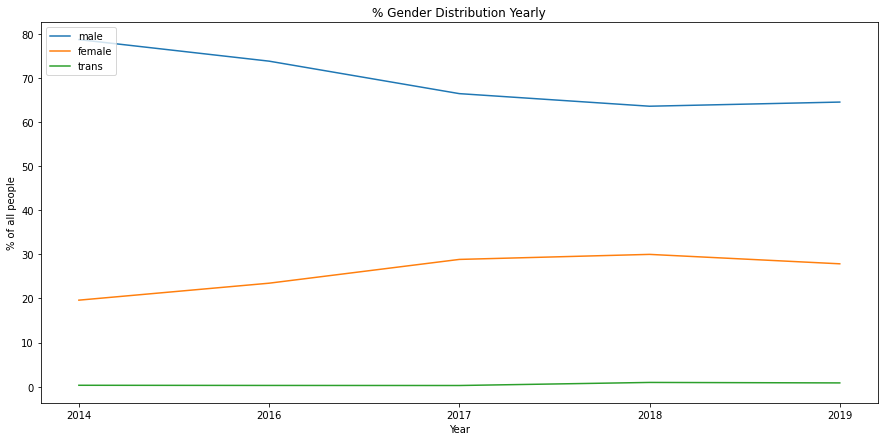

In [930]:
plt.plot(['2014', '2016', '2017', '2018', '2019'], male_list, label="male") 
plt.plot(['2014', '2016', '2017', '2018', '2019'], female_list, label="female") 
plt.plot(['2014', '2016', '2017', '2018', '2019'], trans_list, label="trans") 

plt.title('% Gender Distribution Yearly')
plt.xlabel('Year')
plt.legend(loc="upper left")
plt.ylabel('% of all people') 

#### Race Distribution

Over the years the most frequent race was "white"

In [931]:
q1 = 'What is your race?'
q2 = 'Have you ever sought treatment for a mental health disorder from a mental health professional?'

races_2017 = df_2017[(df_2017[q1] != '-1') & (df_2017[q1] != 'I prefer not to answer')][q1].value_counts()
races_2018 = df_2018[(df_2018[q1] != '-1') & (df_2018[q1] != 'I prefer not to answer')][q1].value_counts()
races_2019 = df_2019[(df_2019[q1] != '-1') & (df_2019[q1] != 'I prefer not to answer')][q1].value_counts()

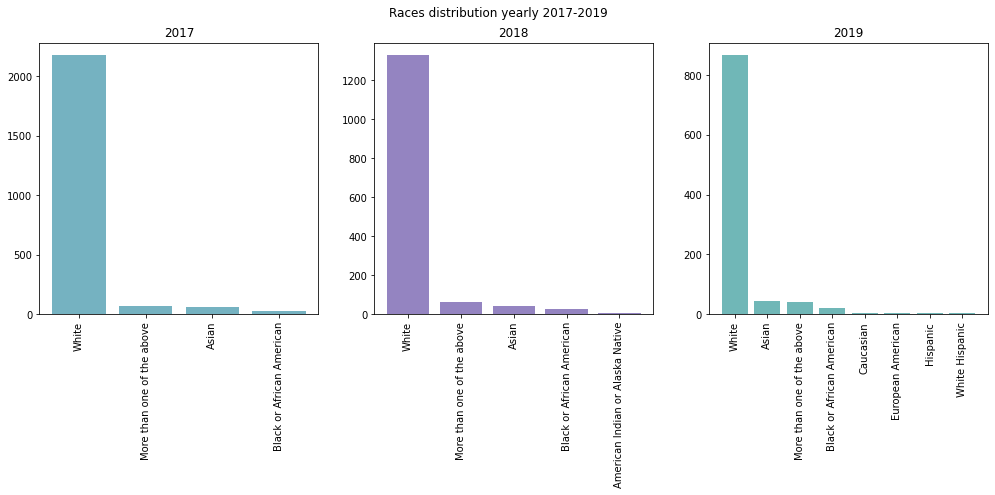

In [932]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

axes[0].bar(range(len(races_2017)), list(races_2017), tick_label=list(races_2017.keys()), color=(0.1, 0.5, 0.6, 0.6))
axes[0].set_title('2017')  
axes[0].tick_params(axis='x', rotation=90)

axes[1].bar(range(len(races_2018)), list(races_2018), tick_label=list(races_2018.keys()), color=(0.3, 0.2, 0.6, 0.6))
axes[1].set_title('2018')  
axes[1].tick_params(axis='x', rotation=90) 

axes[2].bar(range(len(races_2019)), list(races_2019), tick_label=list(races_2019.keys()), color=(0.2, 0.6, 0.6, 0.7))
axes[2].set_title('2019')   
axes[2].tick_params(axis='x', rotation=90)

fig.suptitle('Races distribution yearly 2017-2019')
plt.show() 

#### Have you ever sought treatment for a mental health disorder from a mental health professional?

In the bar plot below, I plotted percentage of people who ever sought for mental health disorder treatment over the years. We can see that the percentage was getting bigger every year.

In [933]:
q = 'Have you ever sought treatment for a mental health disorder from a mental health professional?'

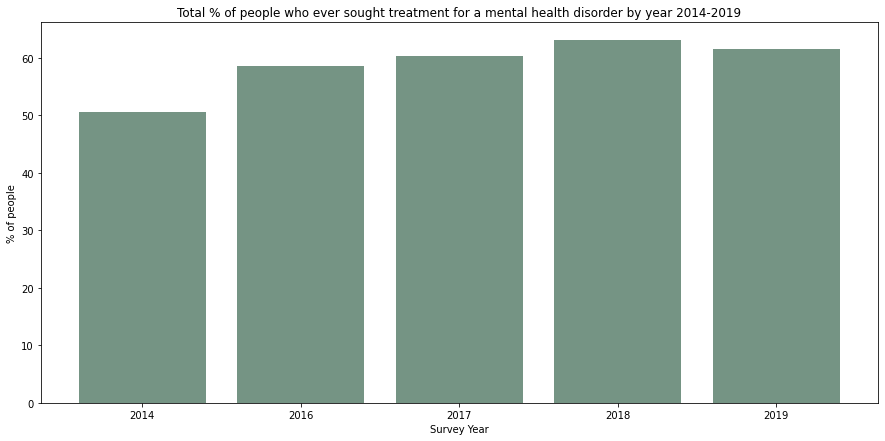

In [934]:
sought_treatment_data = []
sought_treatment_data.append(len(df_2014[df_2014[q] == '1']) / len(df_2014) * 100)
sought_treatment_data.append(len(df_2016[df_2016[q] == '1']) / len(df_2016) * 100)
sought_treatment_data.append(len(df_2017[df_2017[q] == '1']) / len(df_2017) * 100)
sought_treatment_data.append(len(df_2018[df_2018[q] == '1']) / len(df_2018) * 100)
sought_treatment_data.append(len(df_2019[df_2019[q] == '1']) / len(df_2019) * 100)
 
years = ['2014', '2016', '2017', '2018', '2019']

plt.bar(range(len(years)), sought_treatment_data, tick_label=years, color=(0.1, 0.3, 0.2, 0.6))
plt.title('Total % of people who ever sought treatment for a mental health disorder by year 2014-2019')   
plt.xlabel('Survey Year')   
plt.ylabel('% of people')    
plt.show() 

##### By Gender

The pie plots below show that out of all the people who ever sought for mental health help the largest percentage was men in all years between 2014 and 2019. But we can also see a percentage of female users getting bigger from 2017.

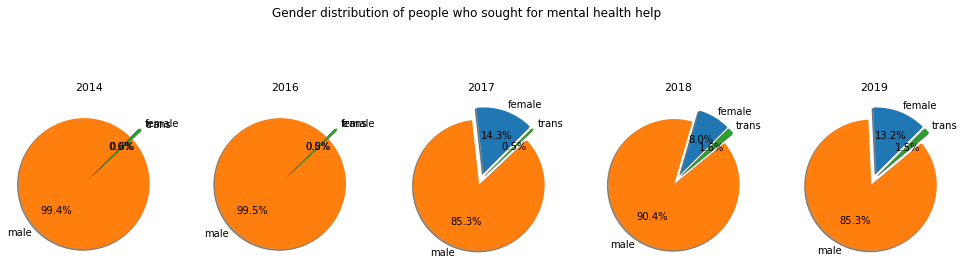

In [935]:
dfs = [df_2014, df_2016, df_2017, df_2018, df_2019]
fig, axes = plt.subplots(1, 5, figsize=(17, 5))
i = 0

for df in dfs:
  df_yes = df[df[q] == '1']

  female = len(df_yes[(df_yes['What is your gender?'] == 'Female') | (df_yes['What is your gender?'] == 'female')])
  male = len(df_yes[(df_yes['What is your gender?'] == 'Male') | (df_yes['What is your gender?'] == 'male')])
  trans = len(df[(df['What is your gender?'].str.contains('Trans') == True) | 
                  (df['What is your gender?'].str.contains('trans') == True)])
    
  data = [female, male, trans]

  label = ['female', 'male', 'trans']

  axes[i].pie(data, labels=label, autopct='%1.1f%%', explode=[0.1,0.1,0.1], shadow=True, startangle=45)
  axes[i].set_title(years[i], fontsize = 11)
  i+=1
 
fig.suptitle('Gender distribution of people who sought for mental health help') 
plt.show()

We can see that over the years, the most people who ever sought for mental health help were at age around 32-38

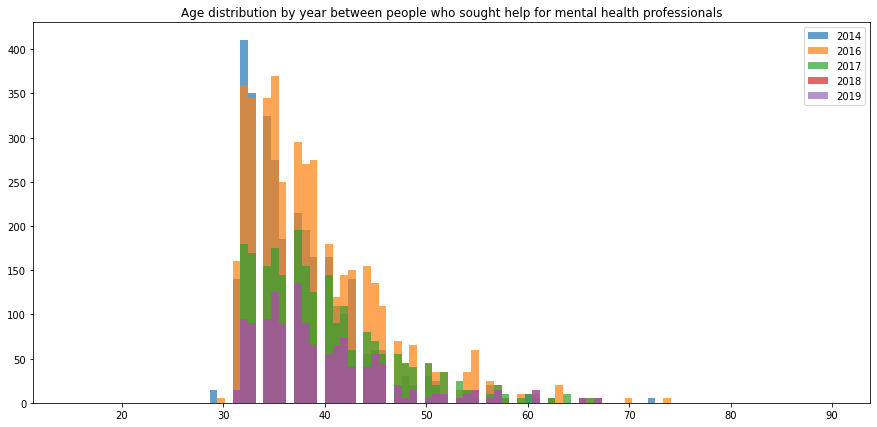

In [936]:
df1 = df_2014[df_2014[q] == '1']  
df2 = df_2016[df_2016[q] == '1']  
df3 = df_2017[df_2017[q] == '1']  
df4 = df_2018[df_2018[q] == '1']  
df5 = df_2018[df_2018[q] == '1']  
    
bins = np.linspace(15, 90, 100)

plt.hist(pd.to_numeric(df1['What is your age?']), bins, label='2014', alpha=0.7) 
plt.hist(pd.to_numeric(df2['What is your age?']), bins, label='2016', alpha=0.7) 
plt.hist(pd.to_numeric(df3['What is your age?']), bins, label='2017', alpha=0.7) 
plt.hist(pd.to_numeric(df4['What is your age?']), bins, label='2018', alpha=0.7) 
plt.hist(pd.to_numeric(df5['What is your age?']), bins, label='2019', alpha=0.7) 

plt.legend(loc='upper right')

plt.title('Age distribution by year between people who sought help for mental health professionals')
plt.show()

##### By employment

In [937]:
dfs = [df_2014, df_2016, df_2017, df_2018, df_2019]
yearly_sought_self_employed = []
yearly_NOT_sought_self_employed = []

for df in dfs:
  q1 = 'Are you self-employed?'
  q2 = 'Have you ever sought treatment for a mental health disorder from a mental health professional?'

  all_self_employed = df[df[q1] == '1']
  all_NOT_self_employed = df[df[q1] == '0']

  sought_self_employed = all_self_employed[all_self_employed[q2] == '1']
  sought_NOT_self_employed = all_NOT_self_employed[all_NOT_self_employed[q2] == '1']

  percent_sought_self_employed = len(sought_self_employed) / len(all_self_employed) * 100
  percent_sought_NOT_self_employed = len(sought_NOT_self_employed) / len(all_NOT_self_employed) * 100

  yearly_sought_self_employed.append(percent_sought_self_employed)
  yearly_NOT_sought_self_employed.append(percent_sought_NOT_self_employed)

The line graph below shows how likely are self and not self employed people to seek for mental health help. We can see that over the years 100% of the self employed people sought for mental health help and the percentage is much smaller for people who are not self employed.

Nevertheless, we can see a growing tendency over the years for not self employed people as well.

Text(0, 0.5, '% of all people')

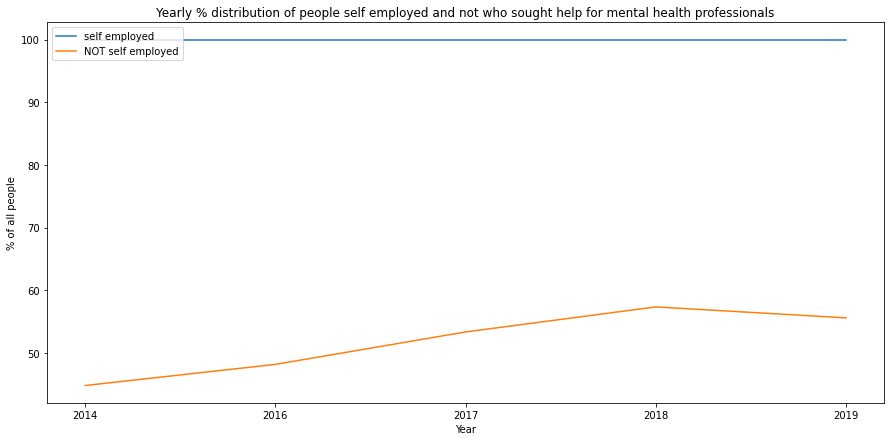

In [938]:
plt.plot(['2014', '2016', '2017', '2018', '2019'], yearly_sought_self_employed, label="self employed") 
plt.plot(['2014', '2016', '2017', '2018', '2019'], yearly_NOT_sought_self_employed, label="NOT self employed") 
 
plt.title('Yearly % distribution of people self employed and not who sought help for mental health professionals')
plt.legend(loc="upper left")
plt.xlabel('Year')
plt.ylabel('% of all people') 

In [939]:
q1 = 'Do you work remotely?'
q2 = 'Have you ever sought treatment for a mental health disorder from a mental health professional?'

df = df_2016 
 
all_always = df[df[q1] == 'Always']
all_sometimes = df[df[q1] == 'Sometimes']
all_never = df[df[q1] == 'Never']

The pie plots below show that 100% of people who always work remotely did not seek for mental health help.

And 100% of people who sometimes work remotely sought for mental health help.

Out of all people who never work remotely, 24.6% sought for mental health help and 75.4% did not.

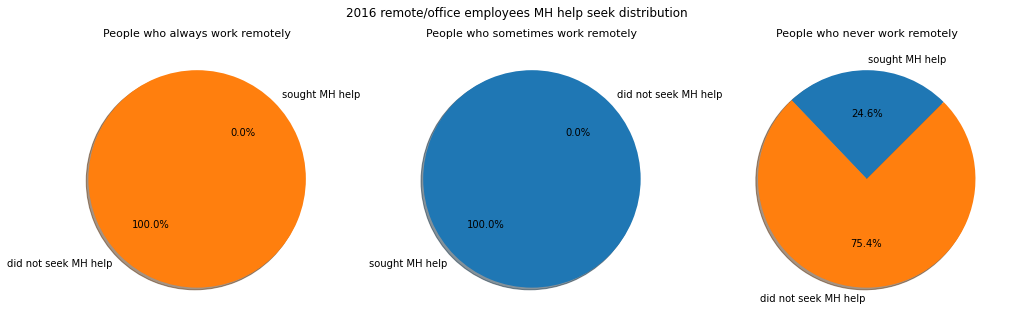

In [940]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
 
label = ['sought MH help', 'did not seek MH help']
axes[0].pie([len(all_always[all_always[q2] == '1']),
         len(all_always[all_always[q2] == '0'])], labels=label,
         autopct='%1.1f%%', shadow=True, startangle=45)
axes[0].set_title('People who always work remotely', fontsize = 11)

axes[1].pie([len(all_sometimes[all_sometimes[q2] == '1']),
         len(all_sometimes[all_sometimes[q2] == '0'])], labels=label,
         autopct='%1.1f%%', shadow=True, startangle=45)
axes[1].set_title('People who sometimes work remotely', fontsize = 11)

axes[2].pie([len(all_never[all_never[q2] == '1']),
         len(all_never[all_never[q2] == '0'])], labels=label,
         autopct='%1.1f%%', shadow=True, startangle=45)
axes[2].set_title('People who never work remotely', fontsize = 11)

fig.suptitle("2016 remote/office employees MH help seek distribution") 
plt.show()

I wanted to see maybe there is a correlation between company size and willingness to seek for mental health help.

But we can see that there is no strong tendency between different sizes of companies over the years. 

In [941]:
q1 = 'Have you ever sought treatment for a mental health disorder from a mental health professional?'
q2 = 'How many employees does your company or organization have?'

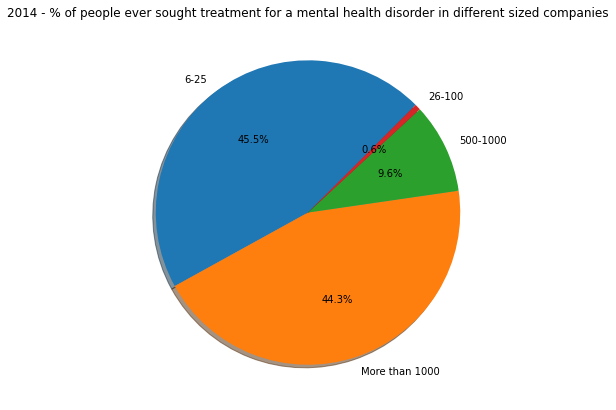

In [942]:
df_sought_2014 = df_2014[df_2014[q1] == '1']
val_2014 = df_sought_2014[q2].value_counts()

plt.pie(list(val_2014), labels=list(val_2014.keys()),
         autopct='%1.1f%%', shadow=True, startangle=45)
plt.title('2014 - % of people ever sought treatment for a mental health disorder in different sized companies')   
plt.show()

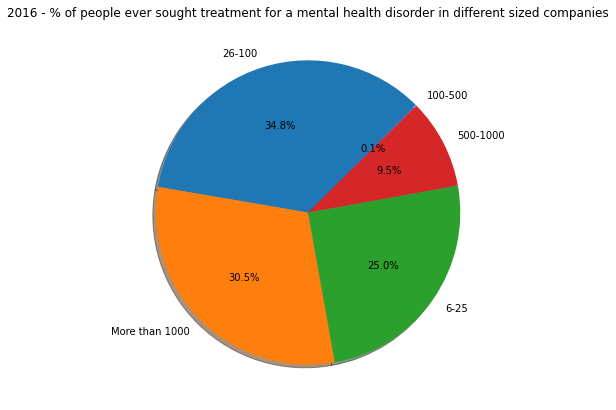

In [943]:
df_sought_2016 = df_2016[df_2016[q1] == '1']
val_2016 = df_sought_2016[q2].value_counts()

plt.pie(list(val_2016), labels=list(val_2016.keys()),
         autopct='%1.1f%%', shadow=True, startangle=45)
plt.title('2016 - % of people ever sought treatment for a mental health disorder in different sized companies')   
plt.show()

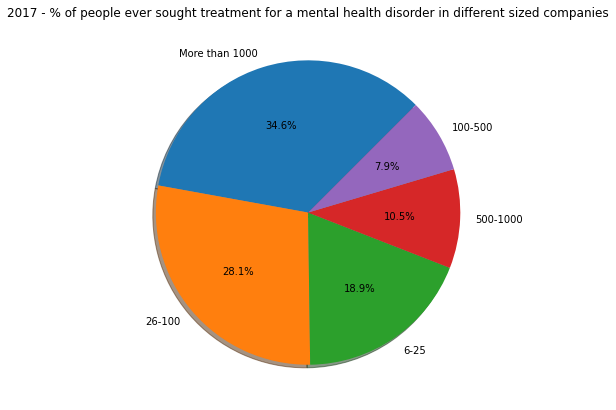

In [944]:
df_sought_2017 = df_2017[df_2017[q1] == '1']
val_2017 = df_sought_2017[q2].value_counts()

plt.pie(list(val_2017), labels=list(val_2017.keys()),
         autopct='%1.1f%%', shadow=True, startangle=45)
plt.title('2017 - % of people ever sought treatment for a mental health disorder in different sized companies')   
plt.show()

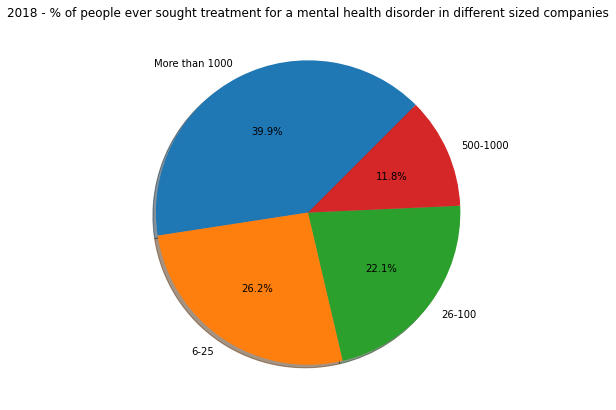

In [945]:
df_sought_2018 = df_2018[df_2018[q1] == '1']
val_2018 = df_sought_2018[q2].value_counts()

plt.pie(list(val_2018), labels=list(val_2018.keys()),
         autopct='%1.1f%%', shadow=True, startangle=45)
plt.title('2018 - % of people ever sought treatment for a mental health disorder in different sized companies')   
plt.show()

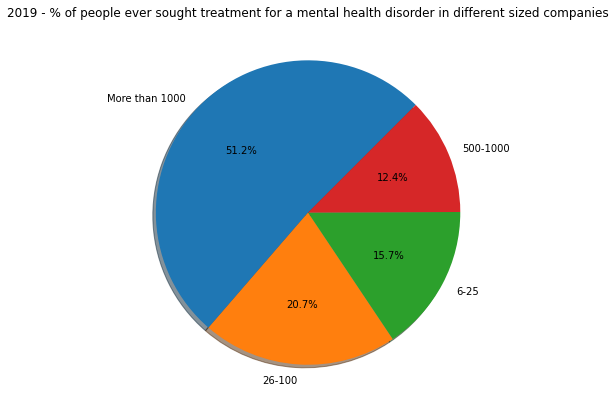

In [946]:
df_sought_2019 = df_2019[df_2019[q1] == '1']
val_2019 = df_sought_2019[q2].value_counts()

plt.pie(list(val_2019), labels=list(val_2019.keys()),
         autopct='%1.1f%%', shadow=True, startangle=45)
plt.title('2019 - % of people ever sought treatment for a mental health disorder in different sized companies')   
plt.show()

##### How many of them were actually diagnosed?

I wanted to see what percent of the people who ever sought for mental health help were actually diagnosed for such disorder.

We can see the percentage getting smaller every year even thought we sought before that larger percentage is actually seeking for mental health help.

In [947]:
dfs = [df_2016, df_2017, df_2018, df_2019]
percentage_sought_and_diagnosed_list = []

for df in dfs:
  q1 = 'Have you ever sought treatment for a mental health disorder from a mental health professional?'
  q2 = 'Have you ever been diagnosed with a mental health disorder?'

  all_sought = df[df[q1] == '1']
  sought_and_diagnosed = all_sought[all_sought[q2] == 'Yes']
  percentage_sought_and_diagnosed = len(sought_and_diagnosed) / len(all_sought) * 100

  percentage_sought_and_diagnosed_list.append(percentage_sought_and_diagnosed)

Text(0, 0.5, '% of all people')

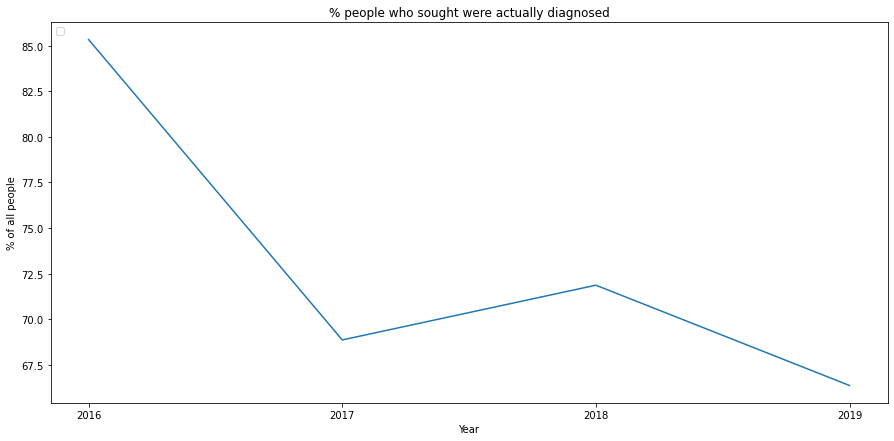

In [948]:
plt.plot(['2016', '2017', '2018', '2019'], percentage_sought_and_diagnosed_list)  

plt.title('% people who sought were actually diagnosed')
plt.xlabel('Year')
plt.legend(loc="upper left")
plt.ylabel('% of all people') 

Even though male are more likely to seek for mental health issues, female takes a significant part of people who were actually diagnosed.

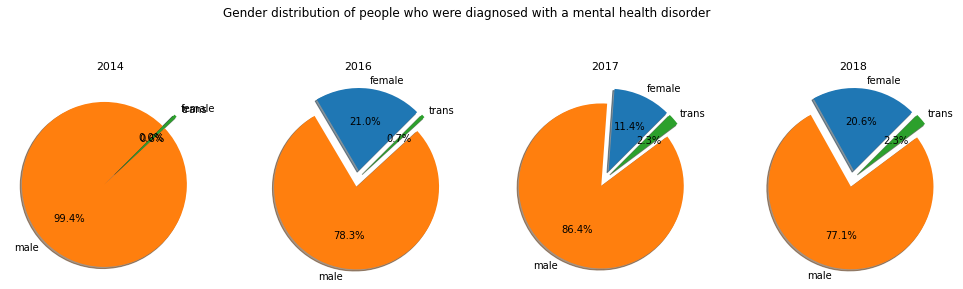

In [949]:
dfs = [df_2016, df_2017, df_2018, df_2019]
fig, axes = plt.subplots(1, 4, figsize=(17, 5))
q = 'Have you ever been diagnosed with a mental health disorder?'
i = 0

for df in dfs:
  df_yes = df[df[q] == 'Yes']

  female = len(df_yes[(df_yes['What is your gender?'] == 'Female') | (df_yes['What is your gender?'] == 'female')])
  male = len(df_yes[(df_yes['What is your gender?'] == 'Male') | (df_yes['What is your gender?'] == 'male')])
  trans = len(df[(df['What is your gender?'].str.contains('Trans') == True) | 
                  (df['What is your gender?'].str.contains('trans') == True)])
    
  data = [female, male, trans]

  label = ['female', 'male', 'trans']

  axes[i].pie(data, labels=label, autopct='%1.1f%%', explode=[0.1,0.1,0.1], shadow=True, startangle=45)
  axes[i].set_title(years[i], fontsize = 11)
  i+=1
 
fig.suptitle('Gender distribution of people who were diagnosed with a mental health disorder') 
plt.show()

#### Mental health disorders

Only survey in 2016 had question about specific mental health disorders but we can see in the bar plot the most frequent ones.

Mood Disorder (Depression, Bipolar Disorder, etc)      412
Anxiety Disorder (Generalized, Social, Phobia, etc)    345
Attention Deficit Hyperactivity Disorder               121
Post-traumatic Stress Disorder                          69
Obsessive-Compulsive Disorder                           45
Name: AnswerText, dtype: int64


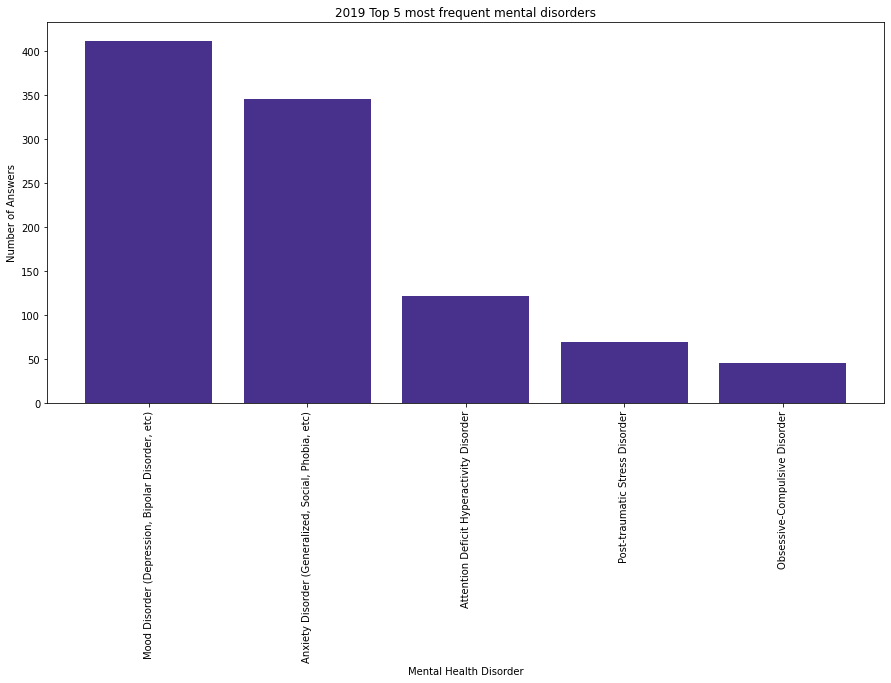

In [950]:
disorders_list = pd.read_sql_query("SELECT AnswerText FROM Answer WHERE SurveyID==2016 AND QuestionID==115", con=db)
disorders_list = disorders_list[disorders_list['AnswerText'] != '-1']

disorders_freq = disorders_list['AnswerText'].value_counts()
disorders_freq = disorders_freq[:5]

print(disorders_freq)

plt.bar(range(len(disorders_freq)), list(disorders_freq),
        tick_label=list(disorders_freq.keys()), color=(0.2, 0.1, 0.5, 0.9))

plt.title(str(year) + ' Top 5 most frequent mental disorders')   
plt.xlabel('Mental Health Disorder')   
plt.xticks(rotation=90)
plt.ylabel('Number of Answers')    
plt.show()    

#### Discussing mental health with coworkers and employers

***If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?***

We can see that people are not very likely to discuss their mental health disorders. A large percent of them even think it would impact them negatively.

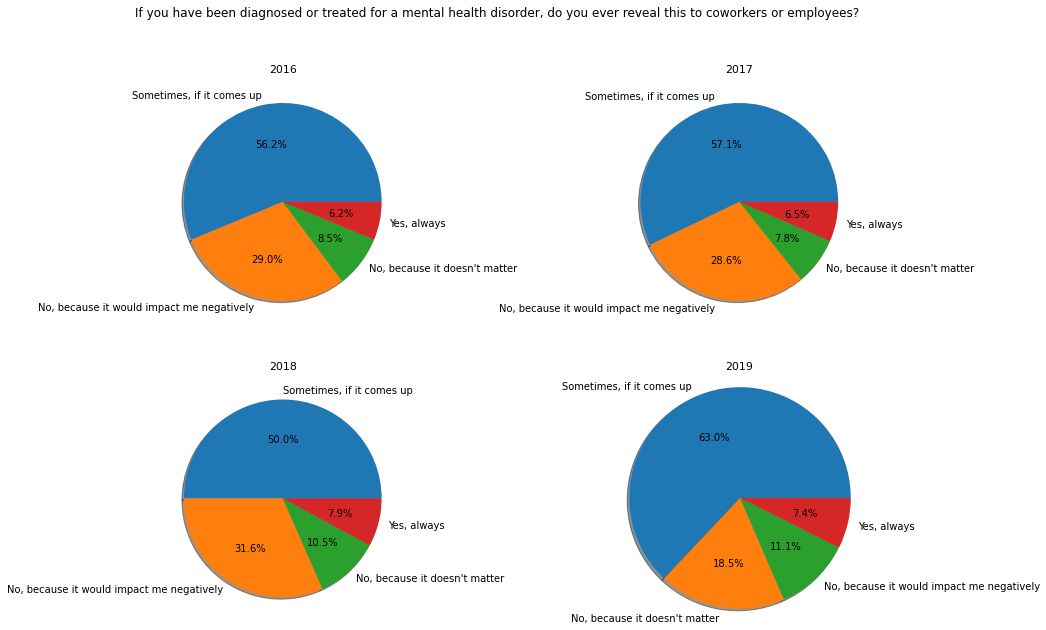

In [951]:
dfs = [df_2016, df_2017, df_2018, df_2019]
year = 2016
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
count = 0

for i in range(0,2):
  for j in range(0,2):
    df = dfs[count]
    q = 'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?'
    results = df[(df[q] != '-1') & (df[q] != 'Not applicable to me')][q].value_counts()
  
    axes[i][j].pie(list(results), labels=list(results.keys()), autopct='%1.1f%%', 
              shadow=True)

    axes[i][j].set_title(year, fontsize = 11)
    year+=1
    count+=1

fig.suptitle('If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?') 
plt.axis('equal')
plt.show()

***Have you ever discussed your mental health with your employer?***

***Have you ever discussed your mental health with coworkers?***

We line graph below shows that people are more likely to discuss mental health with coworkers rather than with employers but the tendency for both is getting higher every year.

Text(0, 0.5, '% of all people')

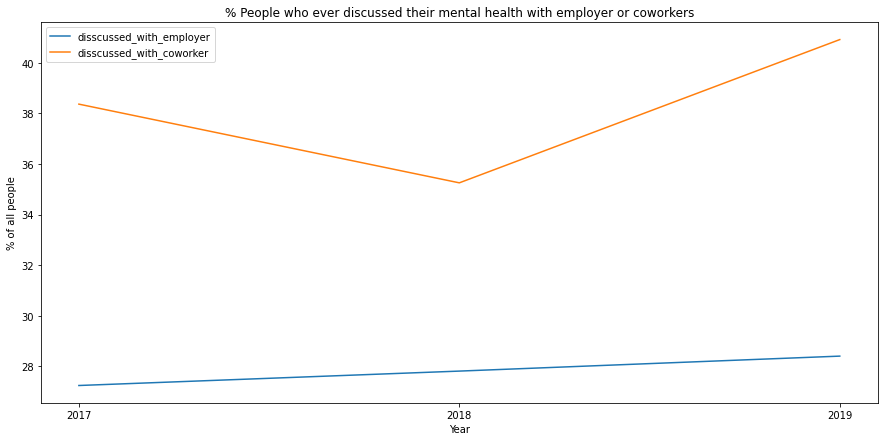

In [952]:
q1 = 'Have you ever discussed your mental health with your employer?'
q2 = 'Have you ever discussed your mental health with coworkers?'

dfs = [df_2017, df_2018, df_2019]
disscussed_with_employer = []
disscussed_with_coworker = []

for df in dfs:
  disscussed_with_employer.append(len(df[df[q1] == '1']) / len(df) * 100)
  disscussed_with_coworker.append(len(df[df[q2] == '1']) / len(df) * 100)

plt.plot(['2017', '2018', '2019'], disscussed_with_employer, label="disscussed_with_employer") 
plt.plot(['2017', '2018', '2019'], disscussed_with_coworker, label="disscussed_with_coworker")  

plt.title('% People who ever discussed their mental health with employer or coworkers')
plt.xlabel('Year')
plt.legend(loc="upper left")
plt.ylabel('% of all people') 

#### Are you openly identified at work as a person with a mental health issue?

The pie plots below show that people are not likely to openly identify themselves as people with mental health issues at work 

In [953]:
q = 'Are you openly identified at work as a person with a mental health issue?'
yes_2018 = len(df_2018[df_2018[q] == '1'])
no_2018 = len(df_2018[df_2018[q] == '0'])

yes_2019 = len(df_2019[df_2019[q] == '1'])
no_2019 = len(df_2019[df_2019[q] == '0'])

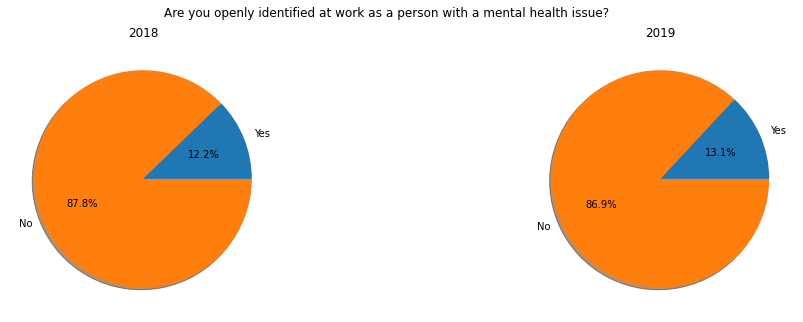

In [954]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

axes[0].pie([yes_2018, no_2018], labels=['Yes', 'No'], autopct='%1.1f%%', shadow=True)
axes[0].set_title('2018')   

axes[1].pie([yes_2019, no_2019], labels=['Yes', 'No'], autopct='%1.1f%%', shadow=True)
axes[1].set_title('2019')    

fig.suptitle('Are you openly identified at work as a person with a mental health issue?')
plt.show()

#### Has your employer ever formally discussed mental health?

We can see a growing tendency of employers discussing mental health issues at work.

In [955]:
questions_employer_discussed = [x for x in df_2014.columns if x.startswith('Has your employer ever')][0]
percent_count_2014 = round((len(df_2014[df_2014[questions_employer_discussed] == 'Yes']) / len(df_2014)) * 100, 2)
questions_employer_discussed = [x for x in df_2016.columns if x.startswith('Has your employer ever')][0]
percent_count_2016 = round((len(df_2016[df_2016[questions_employer_discussed] == 'Yes']) / len(df_2016)) * 100, 2)
questions_employer_discussed = [x for x in df_2017.columns if x.startswith('Has your employer ever')][0]
percent_count_2017 = round((len(df_2017[df_2017[questions_employer_discussed] == 'Yes']) / len(df_2017)) * 100, 2)
questions_employer_discussed = [x for x in df_2018.columns if x.startswith('Has your employer ever')][0]
percent_count_2018 = round((len(df_2018[df_2018[questions_employer_discussed] == 'Yes']) / len(df_2018)) * 100, 2)
questions_employer_discussed = [x for x in df_2019.columns if x.startswith('Has your employer ever')][0]
percent_count_2019 = round((len(df_2019[df_2019[questions_employer_discussed] == 'Yes']) / len(df_2019)) * 100, 2)

In [956]:
employer_discussed_res = [percent_count_2014, percent_count_2016,
                          percent_count_2017, percent_count_2018, percent_count_2019]

Text(0, 0.5, '% of all people')

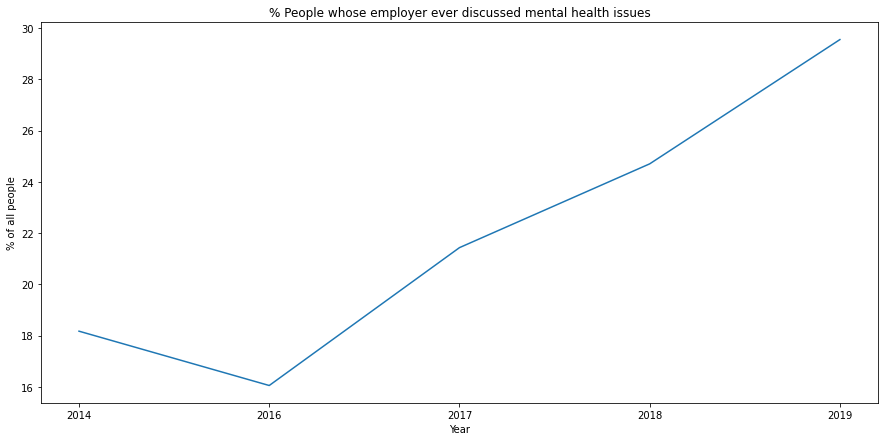

In [957]:
plt.plot(['2014', '2016', '2017', '2018', '2019'], employer_discussed_res) 
plt.title('% People whose employer ever discussed mental health issues')
plt.xlabel('Year') 
plt.ylabel('% of all people') 

## Conclusions

Overall, the dataset helped to understand the distribution of different genders, races and employment types.

We can see a growing tendency of people who sought for mental health help every year. This can either indicate more people with mental health issues or in general more people are interested in their mental health. Moreover, the percentage of employers discussing mental health issues were getting bigger.

* Almost in all years male participants were the largest percent of hte ones who sought for mental health help mostly
* We could also see a growing proportion of both self employed and not people who seek for mental health help. But 100% of self employed people sought for mental health help.
* A large part of people who sought for mental health help actually were diagnosed with mental health disorders but over the years the smaller percentage was actually diagnosed. But this can be influenced by popularity to seek for mental health help.
* Over the years, more employers started discussing mental health issues with their employees
* People who are diagnosed with mental health are still not likely to talk with their colleagues about their problems
* People in general are less likely to discuss mental health in the workplace but they are more likely to discuss these issues with coworkers rather than with employers.
* The most frequent mental health disorders were:
  * Mood Disorder (Depression, Bipolar Disorder, etc)
  * Anxiety Disorder (Generalized, Social, Phobia, etc)
  * Attention Deficit Hyperactivity Disorder
  * Post-traumatic Stress Disorder
  * Obsessive-Compulsive Disorder         